# Wide parameter space searches and Machine learning for CW detection

## Installing and importing libraries

In [24]:
!pip install soapcw


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soapcw
from soapcw import cw
import h5py
import torch
import os

cannot import matplotlib


## Downloading data

In [ ]:
def fetch_data(url, filename):
    """Fetch data from a url and save it to given file"""
    if not os.path.isfile(filename):
        import urllib
        urllib.request.urlretrieve(url, filename=filename)
    else:
        print("File already exists!")

In [ ]:
os.makedirs("data", exist_ok=True)
even_url = "https://github.com/jcbayley/cwworkshop/raw/main/data/freq_100.0_104.1_8160_even.hdf5"
even_file = "data/freq_100.0_104.1_8160_even.hdf5"
fetch_data(even_url, even_file)
# Now for the training data
odd_url = "https://github.com/jcbayley/cwworkshop/raw/main/data/freq_100.0_104.1_8160_odd.hdf5"
odd_file = "data/freq_100.0_104.1_8160_odd.hdf5"
fetch_data(odd_url, odd_file)

# SOAP

SOAP (Snakes On A Plane) is a method to rapidly search for long duration signals in time-frequency spectrograms which do not follow any particular frequency evolution. This has the main goal of identifying signals that may be missed by traditional searches which use information on the expected signal to search for a signal.

There are multiple components to the SOAP search:
1. Initial frequency track identification (model agnostic)
2. ML followup to penalise instrumental lines (some model dependence)
3. Source parameter estimation from frequency tracks (model dependence)


The SOAP package also has the ability to simulate spectrograms (i.e. time-frequency power spectra) of a CW signal. These are by default injected assuming the signal time-series is in stationary Gaussian noise, however, the PSD for each SFT can be changed and a signal can also be injected into real data. 

In [2]:
sig = cw.GenerateSignal()
# define signal parameters
sig.alpha = 3.310726752188296
sig.delta = -0.8824241920781501
sig.cosi = -0.63086
sig.phi0 = 4.007
sig.psi = 0.52563
sig.f = [100.02,-1e-17,0]
sig.tref = 946339148.816094
#sig.h0 = 3e-24 #can be used along with a noise floor value, but we'll just just SNR

In [3]:
nsft, tstart, tsft, flow, fhigh = 48*10, 931042949, 1800., 100.0,100.1
snr = 20

In [4]:
spect = sig.get_spectrogram(tstart = tstart, nsft=nsft,tsft=tsft,fmin=flow,fmax=fhigh,dets=["H1", "L1"],snr=snr)

XLAL Error - XLALReadEphemerisFile (LALInitBarycenter.c:482): Failed to find ephemeris-file 'earth00-19-DE405.dat.gz[.gz]'

XLAL Error - XLALReadEphemerisFile (LALInitBarycenter.c:482): Invalid argument
XLAL Error - XLALInitBarycenter (LALInitBarycenter.c:252): XLALReadEphemerisFile('earth00-19-DE405.dat.gz') failed

XLAL Error - XLALInitBarycenter (LALInitBarycenter.c:252): Internal function call failed: Invalid argument


Could not load ephemeris file: earth00-19-DE405.dat.gz sun00-19-DE405.dat.gz, Internal function call failed: Invalid argument


Spectrograms are usually summed over 1 day to remove the antenna pattern modulation and increase the SNR (assuming the signal stays within a single frequency bin for a day).

In [5]:
spect.sum_sfts()

Text(0, 0.5, 'Frequency [Hz]')

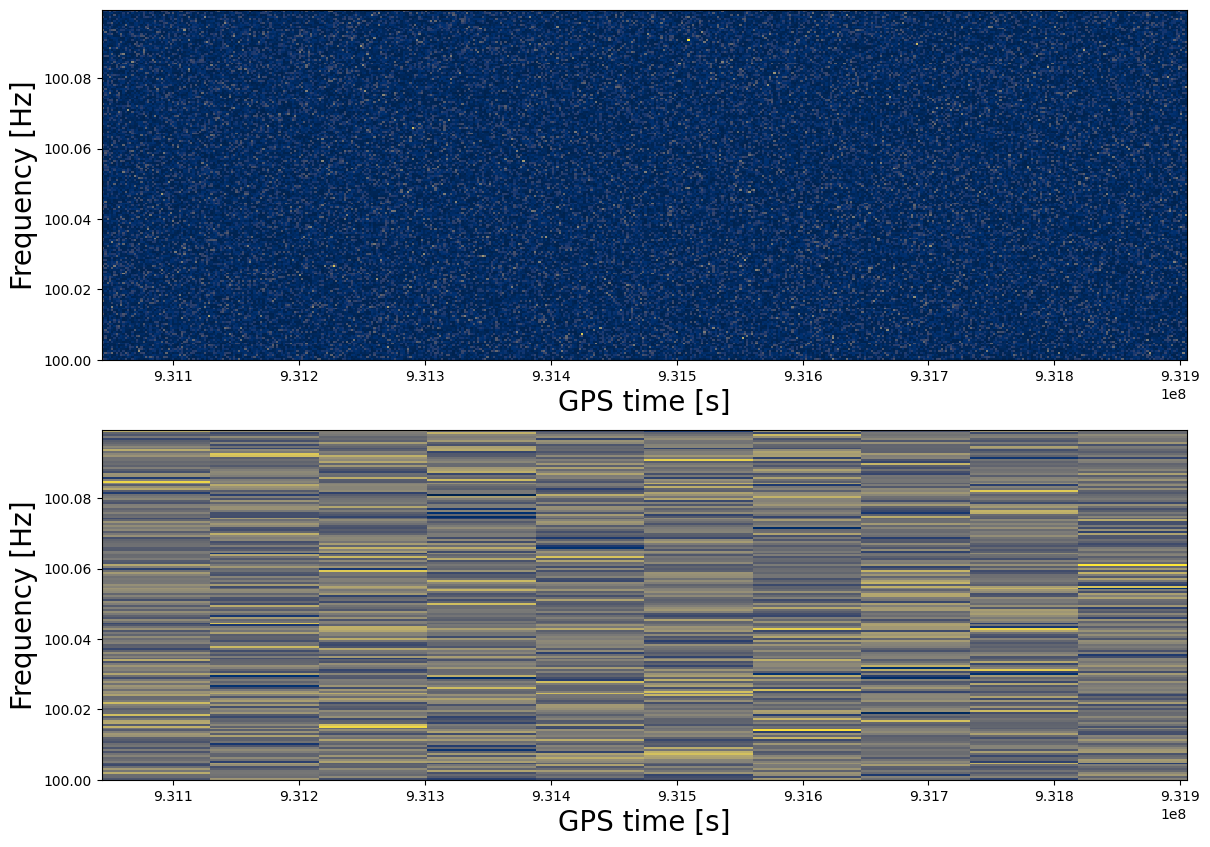

In [6]:
fig, ax = plt.subplots(nrows=2,figsize=(14,10))
ax[0].imshow(spect.H1.norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[1].imshow(spect.H1.summed_norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[0].set_xlabel("GPS time [s]",fontsize=20)
ax[0].set_ylabel("Frequency [Hz]",fontsize=20)
ax[1].set_xlabel("GPS time [s]",fontsize=20)
ax[1].set_ylabel("Frequency [Hz]",fontsize=20)



The transition matrix defines the constraints that are placed on the track as it iterates between one time step and the next. In this case we are using multiple detectors therefore there are three components to the transition matrix. (up/down probability, geocenter to detector 1 probability, geocenter to detector 2 probability).

In [7]:
transition_matrix = soapcw.tools.transition_matrix_2d(1, 1e200,1e200)

/Users/joebayley/miniconda3/envs/soapcw/lib/python3.9/site-packages/soapcw/tools/tools.py:115: RuntimeWarning: divide by zero encountered in log
  return np.log(tr/np.sum(tr))


The SOAP algorithm can then be run by inputting the two normalised and summed spectrograms and the transition matrix.

In [8]:
soapout = soapcw.two_detector(transition_matrix, spect.H1.summed_norm_sft_power, spect.H1.summed_norm_sft_power)

Text(0, 0.5, 'Frequency [Hz]')

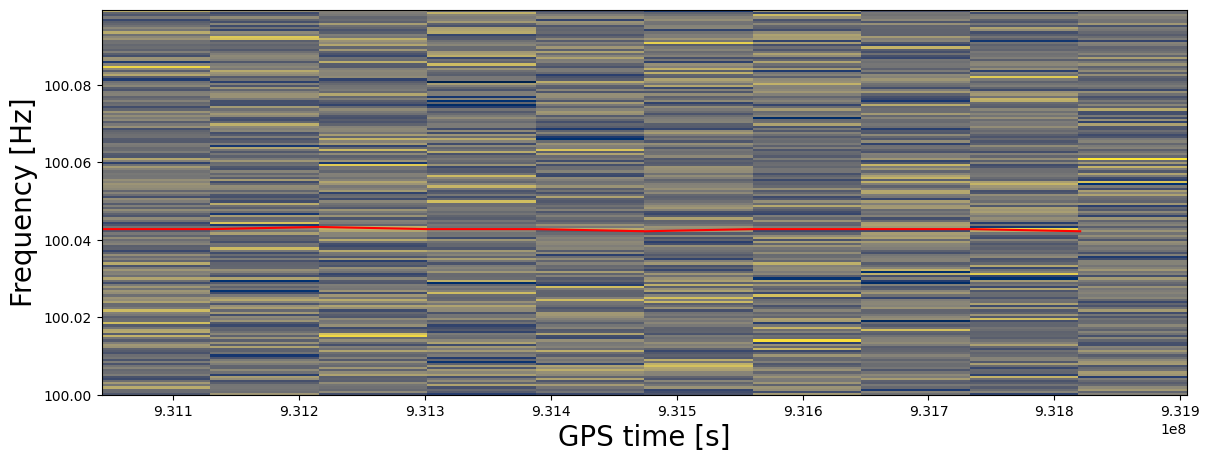

In [9]:
fig, ax = plt.subplots(nrows=1,figsize=(14,5))
ax.imshow(spect.H1.summed_norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax.plot(spect.epochs[::48], spect.frequencies[soapout.vit_track], color="r")
ax.set_xlabel("GPS time [s]",fontsize=20)
ax.set_ylabel("Frequency [Hz]",fontsize=20)

Text(0, 0.5, 'Frequency [Hz]')

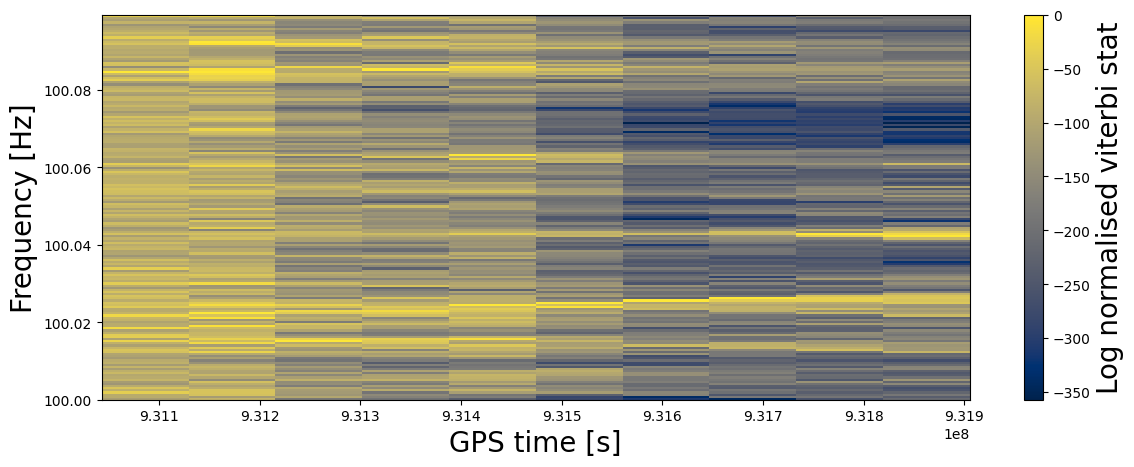

In [10]:
fig, ax = plt.subplots(figsize=(14,5))
img=ax.imshow(np.log(soapout.vitmap.T), origin="lower", aspect="auto", extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
cbar = fig.colorbar(img, ax=ax)
cbar.set_label("Log normalised viterbi stat", fontsize=20)
ax.set_xlabel("GPS time [s]",fontsize=20)
ax.set_ylabel("Frequency [Hz]",fontsize=20)

# Line aware statistic

# Data

Generating useable outputs from the search involves running on many narrow bands of data. We can do this on an example set provided. The provided data contains data with and without injections.

Noise: The noise is equivalent to a Gaussian noise time series, i.e. the power spectrum is a chi2 distribution with two degrees of freedom. 

Signal: The signal is injected with a given SNR, the square of which is used as the non centrality parameter for the noncentral chi2 distribution. The power is spread over multiple bins.

There is a third set of data here which contains some instrumental artefacts to more closely simulate real data.

Each of these datasets are a reduced set, so that we can run searches in a reasonable amount of time.
The duration is 10 days (1800s SFTs) and it covers a 4Hz frequency range (100-104 Hz), where each band in 0.02 Hz wide. As the spectrograms are summed over 1 day, this leaves us with images that are 10x36. 

The injected signals are all very loud with integrated SNRs in the range 30->40 over 10 days. This will allow the network to learn something with a reduced number of training examples. 

One thing you will notice here is the bands have been split into an "even" and "odd" category. Each sub-band is alternately put in to each of the categories. This is so that a separate machine learning model can be trained on each and tested on the opposite, this means we are never training on testing data. 

In [11]:
with h5py.File("./data_gauss2/freq_100.0_104.1_8160_even.hdf5","r") as f:
    print(f.keys())
    even_stats = np.array(f["stats"])
    even_imgs = np.transpose(np.array([np.array(f["H_imgs"]), np.array(f["L_imgs"]), np.array(f["vit_imgs"])]), (1, 0, 2, 3))
    even_labels = np.array(f["labels"])
    even_onehotlabels = torch.nn.functional.one_hot(torch.Tensor(even_labels).to(torch.int32).long(), 2)
    #even_snrs = np.array(f["pars"])[:,np.where(list(f["parnames"]) == "snr")]

<KeysViewHDF5 ['H_imgs', 'L_imgs', 'labels', 'noise_parnames', 'noise_pars', 'paths', 'signal_parnames', 'signal_pars', 'stats', 'vit_imgs']>


In [12]:
with h5py.File("./data_gauss2/freq_100.0_104.1_8160_odd.hdf5","r") as f:
    print(f.keys())
    odd_stats = np.array(f["stats"])
    odd_imgs = np.transpose(np.array([np.array(f["H_imgs"]), np.array(f["L_imgs"]), np.array(f["vit_imgs"])]), (1, 0, 2, 3))
    odd_labels = np.array(f["labels"])
    odd_onehotlabels = torch.nn.functional.one_hot(torch.Tensor(odd_labels).to(torch.int32).long(), 2)

<KeysViewHDF5 ['H_imgs', 'L_imgs', 'labels', 'noise_parnames', 'noise_pars', 'paths', 'signal_parnames', 'signal_pars', 'stats', 'vit_imgs']>


We can have a look at the data that is used in this example. We can see that this is a very small dataset with very load signal, this is to make the machine learning task later managable. 

### SFTs

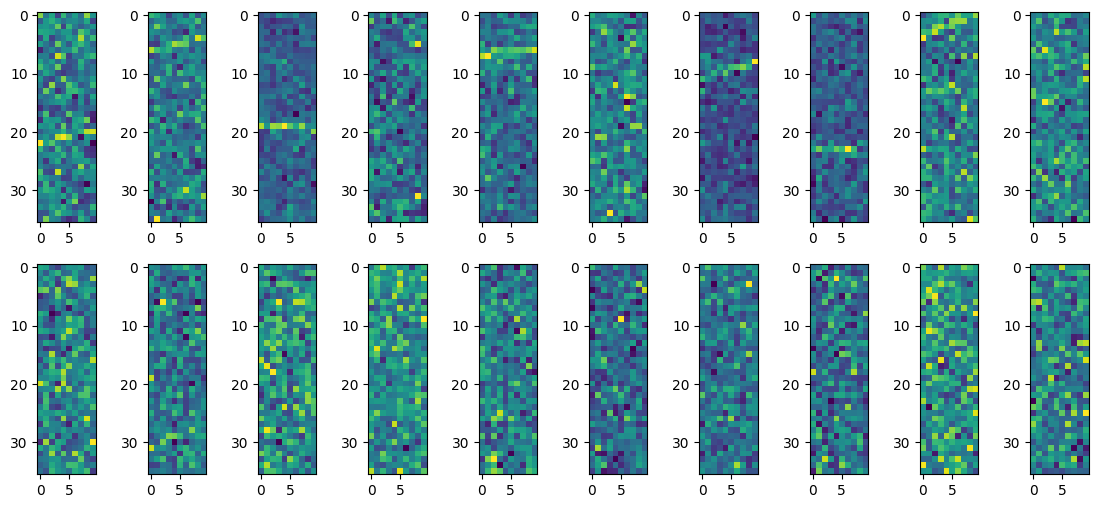

In [13]:
fig, ax = plt.subplots(nrows = 2, ncols = 10, figsize = (14, 6))
ind=3
for i in range(10):
    ax[0, i].imshow(odd_imgs[i,0].T)

for i in range(10):
    ax[1, i].imshow(odd_imgs[int(len(odd_imgs)/2) + i,0].T)
#ax.set_title(odd_labels[ind])

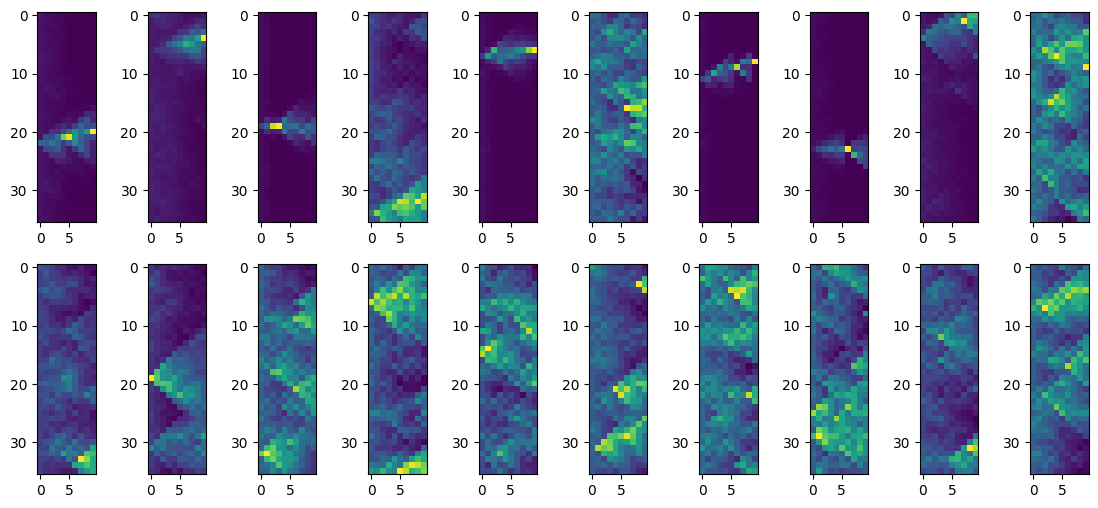

In [14]:
fig, ax = plt.subplots(nrows = 2, ncols = 10, figsize = (14, 6))
ind=3
for i in range(10):
    ax[0, i].imshow(odd_imgs[i,2].T)

for i in range(10):
    ax[1, i].imshow(odd_imgs[int(len(odd_imgs)/2) + i,2].T)
#ax.set_title(odd_labels[ind])

SOAP can be run on all examples in this folder, we can use the included files as the lookup tables

In [15]:
even_soapouts = np.zeros(len(even_imgs))
for index in range(len(even_imgs)):
    out = soapcw.two_detector(transition_matrix, even_imgs[index][0], even_imgs[index][1])
    # soapcw.two_detector(transition_matrix, H_imgs[index], L_imgs[index], lookup_table)
    even_soapouts[index] = out.max_end_prob

In [16]:
odd_soapouts = np.zeros(len(odd_imgs))
for index in range(len(odd_imgs)):
    out = soapcw.two_detector(transition_matrix, odd_imgs[index][0], odd_imgs[index][1])
    # soapcw.two_detector(transition_matrix, H_imgs[index], L_imgs[index], lookup_table)
    odd_soapouts[index] = out.max_end_prob

In [17]:
print(even_soapouts[:10])
print(even_stats[:10])

[2802.07055664 2457.6340332  3067.56079102 2349.64306641 2209.07397461
 2308.66088867 2151.89428711 2292.5012207  3105.07666016 2709.64477539]
[ -4.16367722  -6.64280319   5.0247364   -8.44527817 -10.53305054
 -10.32461452 -11.23687077  -9.89857578   1.8962388    0.64152414]


Text(0, 0.5, 'count')

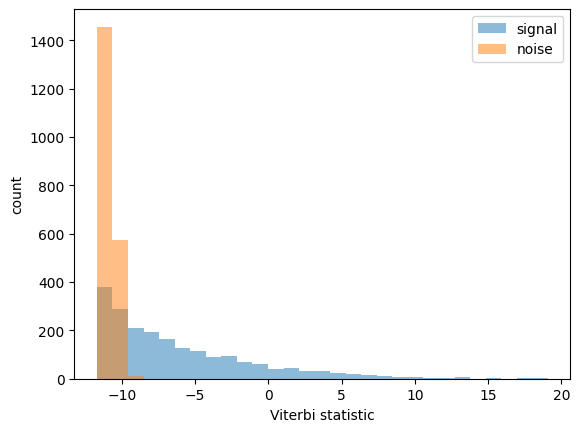

In [18]:
fig, ax = plt.subplots()
bins = np.linspace(min(odd_stats), max(odd_stats), 30)
hst = ax.hist(odd_stats[even_labels == 1], bins=bins, label="signal", alpha=0.5)
hst2 = ax.hist(odd_stats[even_labels == 0], bins=bins, label="noise", alpha=0.5)
ax.legend()
ax.set_xlabel("Viterbi statistic")
ax.set_ylabel("count")

Text(0, 0.5, 'count')

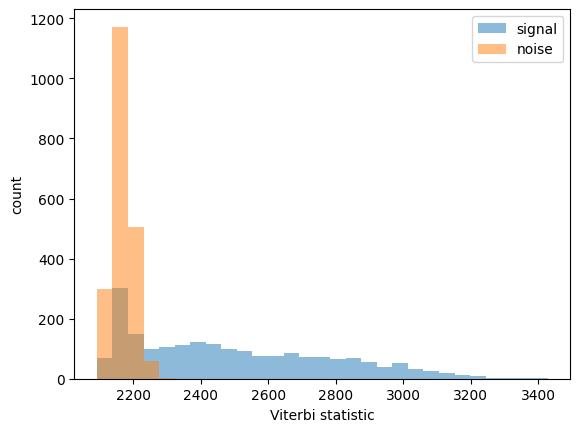

In [19]:
fig, ax = plt.subplots()
bins = np.linspace(min(odd_soapouts), max(odd_soapouts), 30)
hst = ax.hist(odd_soapouts[even_labels == 1], bins=bins, label="signal", alpha=0.5)
hst2 = ax.hist(odd_soapouts[even_labels == 0], bins=bins, label="noise", alpha=0.5)
ax.legend()
ax.set_xlabel("Viterbi statistic")
ax.set_ylabel("count")

# Machine Learning

So far we have a dataset from which we want to learn if a signal is present. This falls into the category of binary classification, where we want the model to predict how probable it is that a signal is present. When dealing with binary classification we want to minimise the Binary cross entropy between the truth and the predicted output. This is defined by

In [20]:
#imgshape
print(odd_imgs.shape)
print(even_imgs.shape)

(4080, 3, 10, 36)
(4080, 3, 10, 36)


### Model Setup

We can define some parameters of out model here:

In [21]:
in_channels = 3 #[H,L,vitmap]
outsize = 2 # [noise_prob, signal_prob]
n_epochs = 3000
learning_rate = 4e-4

In [39]:
cnn = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels, 4, (7,7), padding="same"),
    torch.nn.MaxPool2d((1,2)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 4, (3,3)),
    torch.nn.MaxPool2d((1,2)),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.4),
    torch.nn.LazyLinear(16),
    torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(8),
    torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(outsize)
)

/Users/joebayley/miniconda3/envs/soapcw/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


For ease of use this can be written from a config file using SOAP, or input the configuration as a dictionary
    

In [ ]:
model_config = {
    "model_type": "vitmapspectrogram",              # what inputs are used (vitmap and spectrogram)
    "save_dir": "./",                               # where to save model when training
    "learning_rate": 1e-4,                          # the learning rate of the Adam optimiser
    "img_dim": (180, 470),                          # the size of the input image
    "conv_layers": [(4, 7, 2, 1), (4, 3, 2, 1)],    # the convolutional layers (num_filters, filter_size, maxpool_size, stride)
    "avg_pool": 2,                                  # the size of the average pooling layer 
    "fc_layers": [16, 8, 2],                        # the size of the fully connected mlp layers   
    "dropout": 0.4,                                 # the amount of dropout to use (default 0)
    "n_epochs": 100,                                # number of epochs used for training
    "save_interval": 2,                             # how many epochs to save the model after
    "band_types": ["even", "odd"],                  # which bands to train on (here train an odd and an even version)

}

In [ ]:
config = {
    "model": model_config
    "data": data_config
}

### Loss and Optimiser

In [40]:
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [41]:
def train_batch(model, optimiser, loss_function, data, labels, train=True):
    """
    Compute the loss for one batch of training/validation data. If train=True update the model.
    Args
    -------
    model: 
        pytorch model
    optimiser:
    loss_function:
    data: Tensor
    labels: Tensor
    train: bool
        if true updates the model weights and optimiser
    """
    model.train(train)
    if train:
        optimiser.zero_grad()

    outputs = model(data)
    loss = loss_function(outputs, labels)
    if train:
        loss.backward()
        optimiser.step()

    return loss.item()


We can now write out simple training loop. 

In [42]:
tr_losses = np.zeros(n_epochs)
val_losses = np.zeros(n_epochs)
val_inds = np.random.uniform(0, len(odd_imgs), 200).astype(int)
for epoch in range(n_epochs):

    tr_loss = train_batch(cnn, optimiser, loss_fn, torch.Tensor(even_imgs[:,:]), even_onehotlabels.to(torch.float32), train=True)
    with torch.no_grad():
        # only use 200 of the odd bands for validation
        val_loss = train_batch(cnn, optimiser, loss_fn, torch.Tensor(odd_imgs[val_inds,:]), odd_onehotlabels.to(torch.float32)[val_inds], train=False)

    tr_losses[epoch] = tr_loss
    val_losses[epoch] = val_loss
    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, loss: {tr_loss}, val_loss: {val_loss}")

Epoch: 0, loss: 0.7111149430274963, val_loss: 0.6928842067718506
Epoch: 50, loss: 0.6940710544586182, val_loss: 0.6950900554656982
Epoch: 100, loss: 0.6937755942344666, val_loss: 0.6941433548927307
Epoch: 150, loss: 0.6939451694488525, val_loss: 0.6933432221412659
Epoch: 200, loss: 0.6883169412612915, val_loss: 0.6875407695770264
Epoch: 250, loss: 0.644206166267395, val_loss: 0.6342340707778931
Epoch: 300, loss: 0.5736303925514221, val_loss: 0.5457662343978882
Epoch: 350, loss: 0.5188903212547302, val_loss: 0.49039462208747864
Epoch: 400, loss: 0.4908796548843384, val_loss: 0.4596199095249176
Epoch: 450, loss: 0.47373658418655396, val_loss: 0.4402560889720917
Epoch: 500, loss: 0.4579375088214874, val_loss: 0.42327454686164856
Epoch: 550, loss: 0.44781941175460815, val_loss: 0.4133930206298828
Epoch: 600, loss: 0.4520990252494812, val_loss: 0.4147864282131195
Epoch: 650, loss: 0.4369055926799774, val_loss: 0.4050217568874359
Epoch: 700, loss: 0.43650883436203003, val_loss: 0.40027320384

In [26]:
# we can put in images of any size 
inp = torch.randn((20,3,50,190))
out = cnn(inp)
print(inp.shape, out.shape)

torch.Size([20, 3, 50, 190]) torch.Size([20, 2])


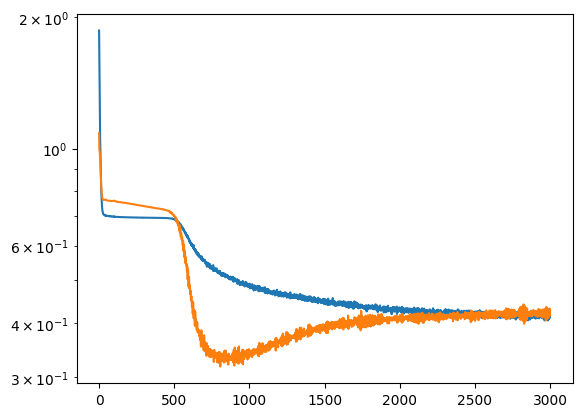

In [35]:
fig, ax = plt.subplots()
ax.plot(tr_losses)
ax.plot(val_losses)
ax.set_yscale("log")
#ax.set_xscale("log")

In [28]:
with torch.no_grad():
    odd_outputs = cnn(torch.Tensor(odd_imgs[:,:]))

In [29]:
odd_outputs

tensor([[-29.3229,  28.4684],
        [-18.7602,  17.8715],
        [-94.6649,  91.4183],
        ...,
        [  0.9655,  -0.9680],
        [  0.9655,  -0.9680],
        [  0.9655,  -0.9680]])

We can compute how well the cnn and SOAP performs by measuring the true positive rate at a false alarm of 1%.

In [30]:
cnn_99per = sorted(odd_outputs[odd_labels==0][:,0])[int(0.99*len(odd_outputs[odd_labels==0]))]
soap_99per = sorted(odd_soapouts[odd_labels==0])[int(0.99*len(odd_outputs[odd_labels==0]))]
print(cnn_99per.numpy(), soap_99per)
cnn_sigfrac = sum(odd_outputs[odd_labels==1][:,1] > cnn_99per)/len(odd_outputs[odd_labels==1])
soap_sigfrac = sum(odd_soapouts[odd_labels==1] > soap_99per)/len(odd_outputs[odd_labels==1])
print(cnn_sigfrac.numpy(), soap_sigfrac)

0.96568215 2248.844482421875
0.6401961 0.7254901960784313


/Users/joebayley/miniconda3/envs/soapcw/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


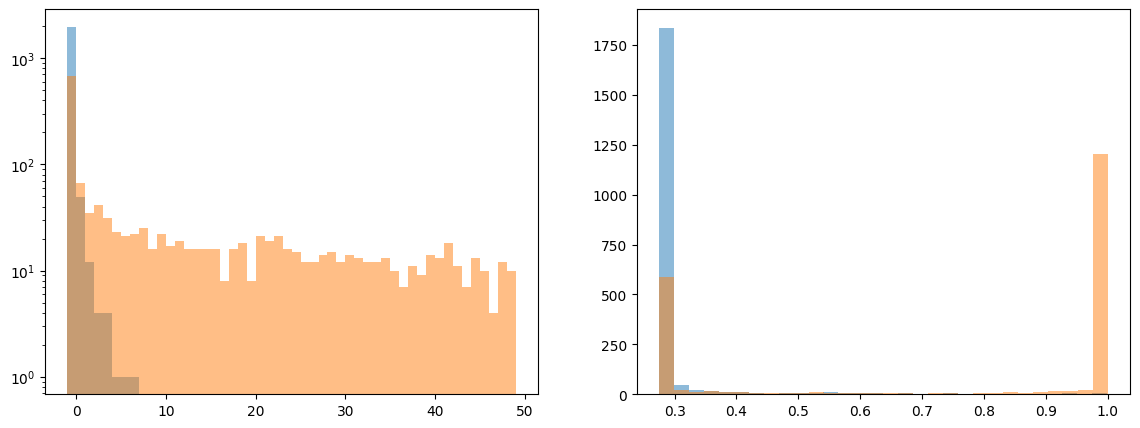

In [33]:
fig, ax = plt.subplots(ncols = 2, figsize=(14,5))
h11 = ax[0].hist(odd_outputs[odd_labels==0][:,1], bins=np.arange(-1,50), alpha=0.5)
h12 = ax[0].hist(odd_outputs[odd_labels==1][:,1], bins=np.arange(-1,50), alpha=0.5)
ax[0].set_yscale("log")
h11 = ax[1].hist(torch.nn.functional.sigmoid(odd_outputs[odd_labels==0][:,1]), bins=30, alpha=0.5)
h12 = ax[1].hist(torch.nn.functional.sigmoid(odd_outputs[odd_labels==1][:,1]), bins=30, alpha=0.5)